# vta: Mini-Challenge Gradient Descent

![image.png](attachment:image.png)

Das Ziel dieser Aufgabe besteht darin, dass Sie ein grundlegendes Verständnis für numerische Näherungsverfahren in höheren Dimensionen erlangen, insbesondere für den Gradient Descent und dessen praktische Anwendung. Hierfür sollen Sie ein Jupyter Notebook erstellen und das MNIST Dataset laden und erkunden. Anschließend sollen Sie ein neuronales Netzwerk erstellen und trainieren, um die Bilder korrekt zu klassifizieren. Es dürfen nur die angegebenen Python packages verwendet werden.

Ziel dieser Aufgabe ist nicht nur, Ihre mathematischen Kenntnisse unter Beweis zu stellen, sondern auch die entsprechende Kommunikation und Präsentation Ihrer Ergebnisse. Ihre Abgaben sollen also nicht nur mathematisch korrekt, sondern auch leicht verständlich und reproduzierbar sein. Genauere Angaben zu den Erwartungen an die Abgabe finden Sie in den Auswertungskriterien. Dokumentieren Sie ihren Arbeitsfortschritt und Erkenntnisgewinn in Form eines Lerntagebuchs, um Lernfortschritte, Schwierigkeiten und Erkenntnisse festzuhalten.
Die folgenden Aufgabenstellungen präzisieren die einzelnen Bearbeitungsschritte und geben die Struktur des Notebooks vor.

- **Project Members:**
- Dominik Filliger
- Noah Leuenberger
- Nils Fahrni
- Oliver Pejic

In [38]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Aufgabe 1
> Laden Sie das MNIST-Dataset mithilfe des torchvision-Pakets (Verwenden Sie das torchvision Paket für diese Aufgabe) und verwenden Sie matplotlib, um sich einen Überblick über die Daten zu verschaffen. Beschreiben Sie das grundlegenden Eigenschaften des Datensets, z.B. wie viele und welche Daten es enthält.

In [39]:
# Define transformations to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract the data and labels from the datasets
X_train, y_train = train_set.data.numpy(), train_set.targets.numpy()
X_test, y_test = test_set.data.numpy(), test_set.targets.numpy()

# Reshape the data to be of size [N x 784]
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

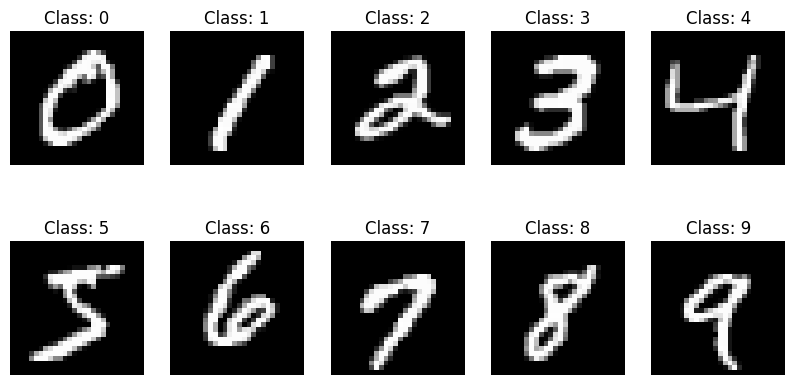

In [40]:
classes = np.unique(y_train)

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[y_train == classes[i]][0].reshape(28, 28), cmap='gray')
    ax.set_title(f"Class: {classes[i]}")
    ax.axis('off')

plt.show()

In [41]:
print('Number of training examples: ', X_train.shape[0])
print('Number of testing examples: ', X_test.shape[0])
print('Each image is of size: ', X_train.shape[1])
print('There are {} classes: {}'.format(len(classes), classes))
print('The data is of type: ', X_train.dtype)
print('The labels are of type: ', y_train.dtype)
print('The range of the pixel values is [{}, {}]'.format(np.min(X_train), np.max(X_train)))

Number of training examples:  60000
Number of testing examples:  10000
Each image is of size:  784
There are 10 classes: [0 1 2 3 4 5 6 7 8 9]
The data is of type:  float64
The labels are of type:  int64
The range of the pixel values is [0.0, 1.0]


In [42]:
for i in range(len(classes)):
    print(f"Class {classes[i]}: {np.sum(y_train == classes[i])} train examples, {np.sum(y_test == classes[i])} test examples")

Class 0: 5923 train examples, 980 test examples
Class 1: 6742 train examples, 1135 test examples
Class 2: 5958 train examples, 1032 test examples
Class 3: 6131 train examples, 1010 test examples
Class 4: 5842 train examples, 982 test examples
Class 5: 5421 train examples, 892 test examples
Class 6: 5918 train examples, 958 test examples
Class 7: 6265 train examples, 1028 test examples
Class 8: 5851 train examples, 974 test examples
Class 9: 5949 train examples, 1009 test examples


## Aufgabe 2

> Erstellen Sie eine Klasse für ein lineares Layer mit beliebig vielen Knoten. Implementieren Sie die Methoden forward, backward und update mithilfe von numpy. Schreiben sie geeignete Unittests, um die Funktionsweise der Funktion zu prüfen.

### Linear Layer

In [43]:
class LinearLayer():
    def __init__(self, input_size, output_size):
        self.x = None
        self.bias_grad = None
        self.weights_grad = None

        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))

    def forward(self, x):
        self.x = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, grad_output):
        self.weights_grad = np.dot(self.x.T, grad_output)
        self.bias_grad = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

    def update(self, lr):
        self.weights -= lr * self.weights_grad
        self.bias -= lr * self.bias_grad

### Unit Testing

In [44]:
import unittest

class TestLinearLayer(unittest.TestCase):
    def setUp(self):
        self.input_size = 10
        self.output_size = 5
        self.linear_layer = LinearLayer(self.input_size, self.output_size)

    def test_forward(self):
        x = np.random.randn(1, self.input_size)
        output = self.linear_layer.forward(x)
        self.assertEqual(output.shape, (1, self.output_size))

    def test_backward(self):
        x = np.random.randn(1, self.input_size)
        output = self.linear_layer.forward(x)
        grad_output = np.random.randn(1, self.output_size)
        grad_input = self.linear_layer.backward(grad_output)
        self.assertEqual(grad_input.shape, (1, self.input_size))

    def test_update(self):
        self.linear_layer.weights = np.array([[1, 2], [3, 4]], dtype=np.float32)
        self.linear_layer.bias = np.array([[1, 2]], dtype=np.float32)
        self.linear_layer.weights_grad = np.array([[1, 2], [3, 4]], dtype=np.float32)
        self.linear_layer.bias_grad = np.array([[1, 2]], dtype=np.float32)

        self.linear_layer.update(0.1)
        self.assertTrue(np.allclose(self.linear_layer.weights, np.array([[0.9, 1.8], [2.7, 3.6]])))
        self.assertTrue(np.allclose(self.linear_layer.bias, np.array([[0.9, 1.8]])))

    def test_shapes(self):
        x = np.random.randn(1, self.input_size)
        output = self.linear_layer.forward(x)
        grad_output = np.random.randn(1, self.output_size)
        grad_input = self.linear_layer.backward(grad_output)

        self.assertEqual(self.linear_layer.weights_grad.shape, (self.input_size, self.output_size))
        self.assertEqual(self.linear_layer.bias_grad.shape, (1, self.output_size))

unittest.main(argv=[''], verbosity=2, exit=False)

test_backward (__main__.TestLinearLayer.test_backward) ... ok
test_forward (__main__.TestLinearLayer.test_forward) ... ok
test_shapes (__main__.TestLinearLayer.test_shapes) ... ok
test_update (__main__.TestLinearLayer.test_update) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.073s

OK


## Aufgabe 3

> Erstellen Sie ein neuronales Netzwerk in numpy mit einem Hidden Linear Layer und einem Output Knoten. Trainieren Sie das Netzwerk darauf, die Ziffer 4 korrekt zu identifizieren (d.h. der Output soll 1 für diese Ziffer und 0 für alle anderen Ziffern sein). Trainieren Sie das Netzwerk auf den Trainingsdaten und evaluieren Sie es anhand von Testdaten. Verwenden Sie eine geeignete Loss-Funktion sowie Accuracy-Funktion und geben Sie deren mathematische Definition an. Begründen Sie Ihre Wahl mit einer Abwägung der Vor- und Nachteile. Diskutieren Sie kurz weitere Optionen für Loss und Accuracy.

### Non-Linear Activation Functions

- https://medium.com/intuitionmath/how-to-implement-the-softmax-derivative-independently-from-any-loss-function-ae6d44363a9d

In [45]:
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return x > 0

def sigmoid(x):
    x = np.clip(x, -500, 500) # clip x to prevent overflow
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True) # prevent overflow
    x = np.exp(x)
    x = x / np.sum(x, axis=1, keepdims=True)
    return x

def softmax_grad(x):
    return softmax(x) * (1 - softmax(x))

### Loss Functions

- https://stats.stackexchange.com/questions/222585/what-are-the-impacts-of-choosing-different-loss-functions-in-classification-to-a


#### Mean Squared Error (MSE)

In [46]:
def mse(y_pred, y_true):
    batch_size = y_pred.shape[0]
    loss = np.sum((y_pred - y_true)**2) / batch_size
    return loss

def mse_grad(y_pred, y_true):
    batch_size = y_pred.shape[0]
    grad = 2 * (y_pred - y_true) / batch_size
    return grad

#### Binary Cross-Entropy / Log Loss
$$
H_p(q)=-\frac{1}{N} \sum_{i=1}^N y_i \cdot \log \left(p\left(y_i\right)\right)+\left(1-y_i\right) \cdot \log \left(1-p\left(y_i\right)\right)
$$

- https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
- https://towardsdatascience.com/where-did-the-binary-cross-entropy-loss-function-come-from-ac3de349a715
- https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function

Derivative:
- https://peterroelants.github.io/posts/cross-entropy-logistic/

In [47]:
def binary_cross_entropy(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()

def binary_cross_entropy_grad(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    return (y_pred - y_true) / (y_pred * (1 - y_pred)) # add eps to prevent division by 0

### Training Development Tracking
In order to track the development of the training process, we define a class that stores the training and validation loss and accuracy for each epoch. We also define a function that plots the training and validation loss and accuracy for each epoch. This allows us to see how the training process develops over time.

In [48]:
class NetworkDevelopment:
    """
    Stores the training and validation loss and accuracy for each epoch.

    Parameters
    ----------
    total_epochs : int
        The total number of epochs the network will be trained.
    """
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs
        self.losses = []
        self.accuracies_train = []
        self.accuracies_test = []

    def add_epoch(self, epoch_number, loss, acc_train, acc_test):
        """
        Adds a new development step to the network development.

        Parameters
        ----------
        loss : float
            The loss of the current epoch.
        acc_train : float
            The accuracy of the training data of the current epoch.
        acc_test : float
            The accuracy of the validation data of the current epoch.
        """
        self.losses.append(loss)
        self.accuracies_train.append(acc_train)
        self.accuracies_test.append(acc_test)

        return f'Epoch {epoch_number}/{self.total_epochs} - loss: {loss:.4f} - acc_train: {acc_train:.4f} - acc_test: {acc_test:.4f}'

    def plot(self):
        """
        Plots the training and validation loss and accuracy for each epoch.
        """
        epochs = np.arange(1, self.total_epochs + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(epochs, self.losses)
        ax1.set_title('Loss over Epochs')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax2.plot(epochs, self.accuracies_train, label='Training')
        ax2.plot(epochs, self.accuracies_test, label='Test')
        ax2.set_title('Accuracy over Epochs')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        plt.show()

    def summary(self):
        """
        Prints the final loss and accuracy of the training and validation data and the average improvements per epoch.
        """
        self.plot()

        print(f'avg acc change / epoch (Training set): {np.mean(np.diff(self.accuracies_train)):.4f}')
        print(f'avg acc change / epoch (Test set): {np.mean(np.diff(self.accuracies_test)):.4f}')
        print(f'avg loss change / epoch: {np.mean(np.diff(self.losses)):.4f}')

#### Batch Creation

The function `get_batches(x, y, batch_size)` creates batches of images and labels from the training set. The number of images in a batch is defined by the batch size. The batch size is a hyperparameter that can be tuned to improve the training process. The batch size is a trade-off between the number of images used for training and the number of training steps per epoch. A larger batch size results in fewer training steps per epoch, but the training process is less accurate. A smaller batch size results in more training steps per epoch, but the training process is more accurate.

In [49]:
def get_batches(x, y, batch_size):
    """
    Returns a generator that yields batches of size batch_size from the given data.

    Parameters
    ----------
    x : numpy.ndarray
        The input data.
    y : numpy.ndarray
        The target data.
    batch_size : int
        The size of each batch.
    """
    n_batches = len(x) // batch_size
    
    # shuffle data before creating batches
    idx = np.random.permutation(len(x))
    x = x[idx]
    y = y[idx]

    for i in range(0, n_batches * batch_size, batch_size):
        x_batch = x[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        yield x_batch, y_batch

### Single-Layer Network 

In [50]:
class SingleLayerNetwork:
    def __init__(self, input_size, hidden_size, output_size, loss_function, loss_function_grad):
        self.dev = None
        self.y_pred = None
        self.h = None
        self.x = None
        self.development = None

        self.loss_function = loss_function
        self.loss_function_grad = loss_function_grad

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear1 = LinearLayer(input_size, hidden_size)
        self.linear2 = LinearLayer(hidden_size, output_size)

    def forward(self, x):
        self.x = x
        self.h = relu(self.linear1.forward(x))
        self.y_pred = sigmoid(self.linear2.forward(self.h))
        return self.y_pred

    def backward(self, y_true):
        y_true = y_true.reshape(-1, 1)
        self.y_pred = self.y_pred.reshape(-1, 1)

        grad_output = self.loss_function_grad(self.y_pred, y_true)

        grad_output = sigmoid_grad(grad_output) * grad_output
        grad_output = self.linear2.backward(grad_output)

        grad_output = relu_grad(grad_output) * grad_output
        grad_output = self.linear1.backward(grad_output)

        return grad_output

    def update(self, lr):
        self.linear1.update(lr)
        self.linear2.update(lr)

    def train(self, X_train, y_train, X_test, y_test, lr, epochs, batch_size, threshold=0.5, output=True):
        self.dev = NetworkDevelopment(total_epochs=epochs)
        
        for epoch in range(epochs):
            loss_list = []
            for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
                y_pred = self.forward(x_batch)
                y_pred = (self.y_pred > 0.5).astype(int)

                loss = self.loss_function(y_pred, y_batch)
                loss_list.append(loss)

                self.backward(y_batch)
                self.update(lr)

            acc_train = self.evaluate(X_train, y_train, threshold)
            acc_test = self.evaluate(X_test, y_test, threshold)
            avg_loss = np.mean(loss_list)

            epoch_str = self.dev.add_epoch(epoch+1, avg_loss, acc_train, acc_test)
            if output:
                print(epoch_str)

    def predict(self, X, threshold=0.5):
        return (self.forward(X) > threshold).astype(int).reshape(-1, 1)

    def evaluate(self, X, y, threshold=0.5):
        y_pred = self.predict(X, threshold).flatten()
        return np.mean(y_pred == y) # TODO: fix deprecation warning

    def summary(self):
        self.dev.summary()

### Training on digit 4

In [51]:
import numpy as np

y_train_binary = (y_train == 4).astype(int)
y_test_binary = (y_test == 4).astype(int)

# Separate the digits
digits = [X_train[y_train == i] for i in range(10)]

# Calculate the number of samples for each not 4 class
samples_per_class = len(digits[4]) // 9


# Prepare the not 4s subset with equal representation of every other digit
X_train_not_4 = np.concatenate([digits[i][:samples_per_class] for i in range(10) if i != 4])
y_train_not_4 = np.concatenate([np.full(samples_per_class, i) for i in range(10) if i != 4])

# Shuffle the not 4s subset
indices_not_4 = np.random.permutation(len(X_train_not_4))
X_train_not_4 = X_train_not_4[indices_not_4]
y_train_not_4 = y_train_not_4[indices_not_4]

# Shuffle the 4s subset
indices_4 = np.random.permutation(len(digits[4]))
X_train_4_only = digits[4][indices_4]
y_train_4_only = np.full(len(digits[4]), 4)

# Create the mixed dataset with a 50:50 split
X_train_mix = np.concatenate((X_train_4_only[:len(X_train_not_4)], X_train_not_4))
y_train_mix = np.concatenate((y_train_4_only[:len(y_train_not_4)], y_train_not_4))

# Shuffle the mixed dataset
indices_mix = np.random.permutation(len(X_train_mix))
X_train_mix = X_train_mix[indices_mix]
y_train_mix = y_train_mix[indices_mix]

# Convert the labels to binary
y_train_mix_binary = (y_train_mix == 4).astype(int)

# Print the count of 4s and not 4s in the train set
print(f"4s: {np.sum(y_train_mix_binary == 1)} - Not 4s: {np.sum(y_train_mix_binary == 0)}")
# do all other numbers

4s: 5841 - Not 4s: 5841


### Training

Epoch 1/20 - loss: 17.2499 - acc_train: 0.8195 - acc_test: 0.8922
Epoch 2/20 - loss: 17.1925 - acc_train: 0.8795 - acc_test: 0.8876
Epoch 3/20 - loss: 17.2009 - acc_train: 0.8807 - acc_test: 0.8964
Epoch 4/20 - loss: 17.2207 - acc_train: 0.8334 - acc_test: 0.9241
Epoch 5/20 - loss: 17.2487 - acc_train: 0.7398 - acc_test: 0.9222
Epoch 6/20 - loss: 17.2345 - acc_train: 0.6526 - acc_test: 0.9197
Epoch 7/20 - loss: 17.2865 - acc_train: 0.5532 - acc_test: 0.9102
Epoch 8/20 - loss: 17.3275 - acc_train: 0.5143 - acc_test: 0.9037
Epoch 9/20 - loss: 17.2749 - acc_train: 0.5022 - acc_test: 0.9020
Epoch 10/20 - loss: 17.2786 - acc_train: 0.5001 - acc_test: 0.9017
Epoch 11/20 - loss: 17.2619 - acc_train: 0.4999 - acc_test: 0.9018
Epoch 12/20 - loss: 17.2759 - acc_train: 0.5000 - acc_test: 0.9018
Epoch 13/20 - loss: 17.2605 - acc_train: 0.5000 - acc_test: 0.9018
Epoch 14/20 - loss: 17.2635 - acc_train: 0.5000 - acc_test: 0.9018
Epoch 15/20 - loss: 17.2730 - acc_train: 0.5000 - acc_test: 0.9018
Epoc

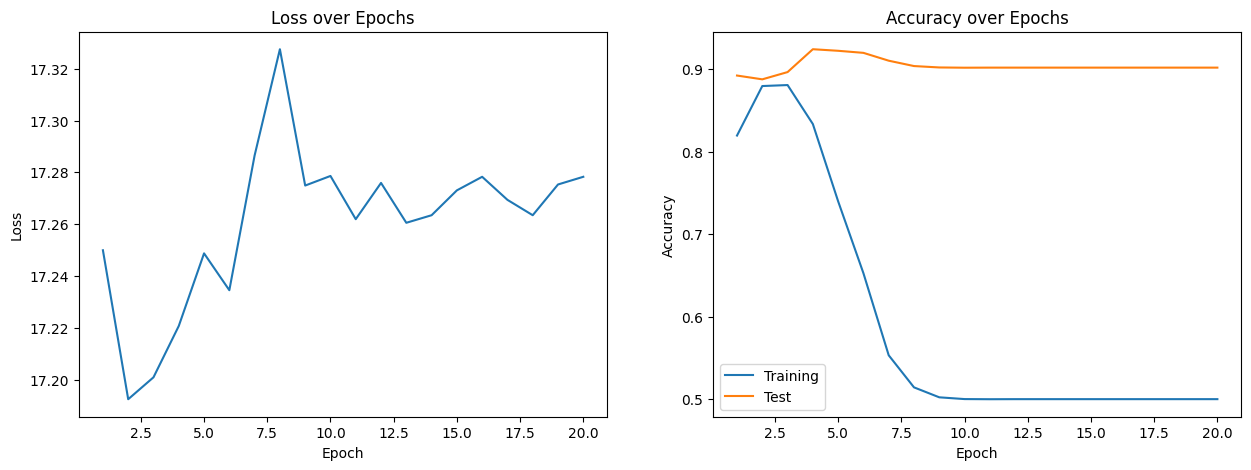

avg acc change / epoch (Training set): -0.0168
avg acc change / epoch (Test set): 0.0005
avg loss change / epoch: 0.0015
Accuracy on 4s: 0.0 - Accuracy on not 4s: 1.0


In [52]:
# Train the network on the mixed train set
network_single_mixed = SingleLayerNetwork(input_size=784, hidden_size=512, output_size=1, loss_function=binary_cross_entropy, loss_function_grad=binary_cross_entropy_grad)
network_single_mixed.train(X_train_mix, y_train_mix_binary, X_test_mix , y_test_mix_binary, lr=0.0001, epochs=20, batch_size=128, threshold=0.5)
network_single_mixed.summary()
acc_4_only = network_single_mixed.evaluate(X_test_4_only, y_test_4_only_binary)
acc_not_4 = network_single_mixed.evaluate(X_test_not_4, y_test_not_4_binary)
print(f"Accuracy on 4s: {acc_4_only} - Accuracy on not 4s: {acc_not_4}")

In [53]:
normal_acc = network_single_mixed.evaluate(X_test, y_test_binary)
print(f"Accuracy on normal test set: {normal_acc}")

Accuracy on normal test set: 0.9018


### Other approaches

In [ ]:
# Train the network on the normal train set
network_single_normal = SingleLayerNetwork(input_size=784, hidden_size=256, output_size=1, loss_function=binary_cross_entropy, loss_function_grad=binary_cross_entropy_grad)
network_single_normal.train(X_train, y_train_4_binary, X_test, y_test_4_binary, lr=0.00001, epochs=10, batch_size=64, threshold=0.5)
network_single_normal.summary()

Epoch 1/10 - loss: 3.6000 - acc_train: 0.9026 - acc_test: 0.9018
Epoch 2/10 - loss: 3.3630 - acc_train: 0.9026 - acc_test: 0.9018
Epoch 3/10 - loss: 3.3641 - acc_train: 0.9026 - acc_test: 0.9018


In [ ]:
# test 4s only
network_single_four = SingleLayerNetwork(input_size=784, hidden_size=256, output_size=1, loss_function=binary_cross_entropy, loss_function_grad=binary_cross_entropy_grad)
network_single_four.train(X_train_4_only, y_train_4_only_binary, X_test, y_test_mix_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)
network_single_four.summary()

### Testing on digit 4

In [ ]:
# test the network
accuracy = network_single_normal.evaluate(X_test, y_test_4_binary, 0.5)
accuracy_4 = network_single_four.evaluate(X_test_4_only, y_test_4_only_binary, 0.5)
accuracy_mix = network_single_mixed.evaluate(X_test, y_test_mix_binary , 0.5)

print(f"Accuracy: {accuracy:.4f} - Accuracy 4s only: {accuracy_4:.4f} - Accuracy mixed: {accuracy_mix:.4f}")

In [ ]:
def cross_entropy(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    loss = -(y_true * np.log(y_pred)).sum(axis=1).mean()
    return loss

def cross_entropy_grad(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    grad = y_pred - y_true
    return grad

def focal_loss(y_pred, y_true, gamma=2):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    loss = -(y_true * np.log(y_pred) * (1 - y_pred) ** gamma).sum(axis=1).mean()
    return loss

def focal_loss_grad(y_pred, y_true, gamma=2):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    grad = (y_pred - y_true) * (1 - y_pred) ** gamma
    return grad

def kullback_leibler_divergence(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    # utilize np.where
    loss = np.where(y_true == 1, y_true * np.log(y_true / y_pred), 0).sum(axis=1).mean()
    return loss

def kullback_leibler_divergence_grad(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    grad = y_true / y_pred - 1
    return grad


In [ ]:
# maybe training more different sets helps
#network_single_all = SingleLayerNetwork(input_size=784, hidden_size=256, output_size=1)
#network_single_all.train(X_train_mix, y_train_mix_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)
#network_single_all.train(X_test, y_train_4_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)

#accuracy_all = network_single_all.evaluate(X_test, y_test_4_binary, 0.5)
#accuracy_all_4 = network_single_all.evaluate(X_test_4_only, y_test_4_only_binary, 0.5)
#accuracy_all_mix = network_single_all.evaluate(X_test, y_test_mix_binary , 0.5)

#print(f"Accuracy: {accuracy_all:.4f} - Accuracy 4s only: {accuracy_all_4:.4f} - Accuracy mixed: {accuracy_all_mix:.4f}")

## Aufgabe 4

> Trainieren Sie das Netzwerk mit verschiedenen Lernraten und Größen des Hidden Layers. Verfolgen Sie während des Trainings die Entwicklung der Loss- und Accuracy-Funktionen auf Trainings- und Testdatensätzen und entscheiden Sie, welche Wahl von Lernrate und Hidden Layer-Größe die besten Ergebnisse in geringster Zeit liefert.

### Finding the right hyperparameters

In order to find the right hyperparameters, we define a function that trains the network with different learning rates, epochs, hidden layer sizes and batch sizes. The result for each combination is then stored and analyzed.

This brute force approach is not very efficient, but it allows us to find the best hyperparameters for the network.

> **Note:** The brute force process takes a long time to complete. Therefore, we have commented out the code that runs the brute force process. The best result is described further below.

In [ ]:
def get_param_combinations(epochs, batch_sizes, learning_rates, hidden_sizes):
    return [(e, b, l, h) for e in epochs for b in batch_sizes for l in learning_rates for h in hidden_sizes]

In [ ]:
import time

epochs = [10, 20, 30]
batch_sizes = [2**i for i in range(4, 11)]
learning_rates = [10**-i for i in range(1, 8)]
hidden_sizes = [32, 64, 128, 256, 512]
combinations = get_param_combinations(epochs, batch_sizes, learning_rates, hidden_sizes)
print(f"Testing {len(combinations)} parameter combinations")

results = []
for i in range(len(combinations)):
    e, b, l, h = combinations[i]
    network = SingleLayerNetwork(input_size=784, hidden_size=h, output_size=1, loss_function=binary_cross_entropy, loss_function_grad=binary_cross_entropy_grad)

    start = time.time()
    network.train(X_train, y_train_4_binary, X_test, y_test_4_binary, lr=l, epochs=e, batch_size=b, output=False)
    end = time.time()

    total_time = end - start
    accuracy = network.evaluate(X_test, y_test_4_binary)

    #accuracy_4 = network.evaluate(X_test_4_only, y_test_4_only_binary)

    #network_mix = SingleLayerNetwork(input_size=784, hidden_size=h, output_size=1)
    #network_mix.train(X_train_mix, y_train_mix_binary, lr=l, epochs=e, batch_size=b)

    #accuracy_mix = network_mix.evaluate(X_test, y_test_4_binary)
    #accuracy_mix_4 = network_mix.evaluate(X_test_4_only, y_test_4_only_binary)

    # save the results
    result = (e, b, l, h, accuracy, total_time)
    results.append(result)

    print(f"combo {i+1}/{len(combinations)}: - Epochs: {e} - Batch size: {b} - Learning rate: {l} - Hidden size: {h} - Accuracy: {accuracy:.4f} - Time: {total_time:.4f}s")
    #if (accuracy * 0.5 + accuracy_4 * 0.5) > (results[-1][5] + results[-1][4]):
    #    results.append((e, b, l, h, accuracy, accuracy_4, end-start))
    #    print(f"Epochs: {e} - Batch size: {b} - Learning rate: {l} - Hidden size: {h} - Accuracy: {accuracy:.4f} - Accuracy_4: {accuracy_4:.4f}")

In [ ]:
results.sort(key=lambda x: x[4], reverse=True) # sort by accuracy
for r in results[:10]:
    print(f"Epochs: {r[0]} - Batch size: {r[1]} - Learning rate: {r[2]} - Hidden size: {r[3]} - Accuracy: {r[4]:.4f} - Time: {r[5]:.4f}")

### Best Result

The best result was achieved with the following hyperparameters:

## Aufgabe 5

> Erweitern Sie das Netzwerk auf 3 Hidden Layer mit gleicher Größe und 10 Outputs. Das Ziel ist die korrekte Klassifizierung aller Ziffern. Verwenden Sie eine geeignete Loss-Funktion sowie Accuracy-Funktion und geben Sie deren mathematische Definition an. Begründen Sie Ihre Wahl und diskutieren Sie kurz weitere Möglichkeiten. Variieren Sie die Lernrate und die Größe der Hidden Layer und wählen Sie das beste Ergebnis aus.

### Cross-Entropy

$$
J=-\frac{1}{N}\left(\sum_{i=1}^N \mathbf{y}_{\mathbf{i}} \cdot \log \left(\hat{\mathbf{y}}_{\mathbf{i}}\right)\right)
$$



### Gradient of the Cross-Entropy loss function
The reason why the `cross_entropy_grad` function uses the difference between the predicted probabilities and the true labels, instead of the negative of the gradient of the cross-entropy loss with respect to the predicted probabilities, is that they are equivalent up to a constant factor.

Let's first consider the gradient of the cross-entropy loss with respect to the predicted logits, denoted as $\mathbf{z}$. The logits are related to the predicted probabilities via the softmax function:

$$
y_{i} = \frac{e^{z_{i}}}{\sum_{j} e^{z_{j}}}
$$

Taking the partial derivative of $\mathcal{L}$ with respect to $z_{j}$, we have:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = \sum_{i} \frac{\partial \mathcal{L}}{\partial y_{i}} \frac{\partial y_{i}}{\partial z_{j}}
$$

Using the chain rule, we have:

$$
\frac{\partial y_{i}}{\partial z_{j}} = y_{i} (\delta_{ij} - y_{j})
$$

where $\delta_{ij}$ is the Kronecker delta function that is equal to 1 if $i = j$ and 0 otherwise. Substituting this expression into the above equation, we obtain:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = \sum_{i} (\delta_{ij} - y_{j}) t_{i}
$$

This expression is equivalent to the difference between the predicted probabilities and the true labels. To see this, note that the predicted probabilities can be written as:

$$
y_{j} = \frac{e^{z_{j}}}{\sum_{k} e^{z_{k}}}
$$

Taking the derivative of $y_{j}$ with respect to $z_{j}$, we have:

$$
\frac{\partial y_{j}}{\partial z_{j}} = y_{j} (1 - y_{j})
$$

Substituting this expression into the gradient expression, we obtain:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = y_{j} - t_{j}
$$

which is the difference between the predicted probabilities and the true labels. Thus, the `cross_entropy_grad` function is equivalent to the negative of the gradient of the cross-entropy loss with respect to the predicted probabilities, up to a constant factor.



### One-Hot Encoding

In [ ]:
def one_hot_encode(y):
    y_one_hot = np.zeros((len(y), 10))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

# one hot encode the y values for the training and test set
y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

### Multi-Layer Network

In [ ]:
class MultiLayerNetwork:
    def __init__(self, input_size, hidden_size, output_size, loss_function, loss_function_grad):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.loss_function = loss_function
        self.loss_function_grad = loss_function_grad

        self.input_layer = LinearLayer(input_size, hidden_size)
        self.hidden_layer1 = LinearLayer(hidden_size, hidden_size)
        self.hidden_layer2 = LinearLayer(hidden_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)

        self.dev = None
        self.hidden_output1 = None
        self.hidden_output2 = None
        self.hidden_output3 = None
        self.predicted_output = None

    def forward(self, x):
        self.hidden_output1 = relu(self.input_layer.forward(x))
        self.hidden_output2 = relu(self.hidden_layer1.forward(self.hidden_output1))
        self.hidden_output3 = relu(self.hidden_layer2.forward(self.hidden_output2))
        self.predicted_output = softmax(self.output_layer.forward(self.hidden_output3))
        return self.predicted_output

    def backward(self, y_true):
        gradient_output = self.loss_function_grad(self.predicted_output, y_true)

        gradient_output = softmax_grad(self.predicted_output) * gradient_output
        gradient_output = self.output_layer.backward(gradient_output)

        gradient_output = relu_grad(self.hidden_output3) * gradient_output
        gradient_output = self.hidden_layer2.backward(gradient_output)

        gradient_output = relu_grad(self.hidden_output2) * gradient_output
        gradient_output = self.hidden_layer1.backward(gradient_output)

        gradient_output = relu_grad(self.hidden_output1) * gradient_output
        gradient_output = self.input_layer.backward(gradient_output)

        return gradient_output

    def update(self, learning_rate):
        self.input_layer.update(learning_rate)
        self.hidden_layer1.update(learning_rate)
        self.hidden_layer2.update(learning_rate)
        self.output_layer.update(learning_rate)

    def train(self, X_train, y_train, X_test, y_test, learning_rate, epochs, batch_size, output=True):
        self.dev = NetworkDevelopment(total_epochs=epochs)

        for epoch in range(epochs):
            loss_list = []
            for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
                predicted_output = self.forward(X_batch)

                loss = self.loss_function(predicted_output, y_batch)
                loss_list.append(loss)

                self.backward(y_batch)
                self.update(learning_rate)

            avg_loss = np.mean(loss_list)
            acc_train = self.evaluate(X_train, y_train)
            acc_test = self.evaluate(X_test, y_test)

            epoch_str = self.dev.add_epoch(epoch+1, avg_loss, acc_train, acc_test)
            if output:
                print(epoch_str)

    def predict(self, X):
        predicted_output = self.forward(X)
        return np.argmax(predicted_output, axis=1)

    def evaluate(self, X, y):
        predicted_classes = self.predict(X)
        true_classes = np.argmax(y, axis=1)
        return np.mean(predicted_classes == true_classes)

    def summary(self):
        self.dev.summary()

### Training

In [ ]:
network_single_normal = MultiLayerNetwork(input_size=784, hidden_size=256, output_size=10, loss_function=cross_entropy, loss_function_grad=cross_entropy_grad)
network_single_normal.train(X_train, y_train_one_hot, X_test, y_test_one_hot, learning_rate=0.01, epochs=11, batch_size=46)
network_single_normal.summary()

In [ ]:
network_multi_normal= MultiLayerNetwork(input_size=784, hidden_size=256, output_size=10, loss_function=focal_loss, loss_function_grad=focal_loss_grad)
network_multi_normal.train(X_train, y_train_one_hot, X_test, y_test_one_hot, learning_rate=0.01, epochs=11, batch_size=46)
network_multi_normal.summary()

### Testing

In [ ]:
# evaluate the network on the test set
print(f"Accuracy: {network_single_normal.evaluate(X_test, y_test_one_hot):.4f}")

### Finding the right hyperparameters

In [ ]:
import time

epochs = [10*i for i in range(1, 5)]
batch_sizes = [2**i for i in range(4, 11)]
learning_rates = [10**-i for i in range(2, 8)]
hidden_sizes = [32, 64, 128, 256, 512]
combinations = get_param_combinations(epochs, batch_sizes, learning_rates, hidden_sizes)

print(f"Testing {len(combinations)} parameter combinations")

results = []
for i in range(len(combinations)):
    e, b, l, h = combinations[i]
    net = MultiLayerNetwork(input_size=784, hidden_size=h, output_size=10, loss_function=focal_loss,loss_function_grad=focal_loss_grad)


    start = time.time()
    net.train(X_train, y_train_one_hot, X_test, y_test_one_hot, learning_rate=l, epochs=e, batch_size=b, output=False)
    end = time.time()

    total_time = end - start
    accuracy = net.evaluate(X_test, y_test_one_hot)

    # save the results
    result = (e, b, l, h, accuracy, total_time)
    results.append(result)

    print(f"combo {i+1}/{len(combinations)}: - Epochs: {e} - Batch size: {b} - Learning rate: {l} - Hidden size: {h} - Accuracy: {accuracy:.4f} - Time: {total_time:.4f}s")

## Lerntagebuch

### KW13

### KW14

- Multiplikation Linear Layer vertauscht? input x weights or weights x input

### KW15

### KW16

#### 17.04.

SingleLayerModel:

- Geeignete Loss- und Accuracy-Funktionen
- Die Wahl wurde begründet und mit anderen mögliche Funktionen verglichen?
- Die mathematische Definition der Loss-Funktion und Accuracy-Funktion ist korrekt angege- ben (gerendert in Latex)?
- Die Entwicklung der Loss- und Accuracy-Funktionen wurden auf Trainings- und Testdaten- sätzen korrekt verfolgt und leicht nachvollziehbar dargestellt?
- Die Wahl von Lernrate und Hidden Layer-Größe wurde nachvollziehbar entschieden und begründet.

MultiLayerModel:

- Geeignete Loss- und Accuracy-Funktionen wurden verwendet.
- Die Wahl wurde begründet und mit anderen möglichen Funktionen verglichen.
- Die mathematische Definition der Loss-Funktion und Accuracy-Funktion ist korrekt angegegeben (gerendert in Latex).
- Es wurden verschiedene Lernraten und Größen der Hidden Layer sinnvoll ausprobiert.
- Die Entwicklung der Loss- und Accuracy-Funktionen auf Trainings- und Testdatensätzen wurde korrekt verfolgt und leicht nachvollziehbar dargestellt?
- Die Wahl der Hyperparameter wurde nachvollziehbar entschieden und begründet?

Form:

- Environment angeben (Python 3.10)
- Code comments
- Executive Summary

#### 18.04.

Fragen an Stefan:

- Verständnis Anzahl Layers
- Aufgabe 3: Biased Training? Interpretation von unseren Resultaten?
- Keine Gradienten Berechnung im LinearLayer (Punkt 5)
- 7) Geeignete Loss- und Accuracy-Funktionen wurden verwendet.
- Lerntagebuch auch im Notebook? Summary on top?
- Time import bei Aufgabe 4 erlaubt? (Zeitmessung oder Epochen gemeint)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=88bc6171-47da-4cbc-96f1-ee851c7ac9ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>